In [15]:
import random

import numpy as np
import seaborn as sns

from scipy.stats import beta, bernoulli
from matplotlib import pyplot as plt

# Многорукие бандиты

Подход к A/B-тестированию, который мы рассмотрели, называется частотным. При таком подходе до окончания периода эксперимента нельзя перераспределять пользователей в группах, что на практике может привести к потерям.

Существует подход, позволяющий менять соотношение объёмов выборок — подход **многоруких бандитов** (MAB, multi-armed bandit)

Многорукий бандит — набор распределений "вознаграждений" $B = \left\{ R_1, ..., R_k \right\}$ (можно представить как ряд из нескольких одноруких бандитов). $\mu_1, ..., \mu_k$ — средние распределений. Игрок дёргает ручки автоматов, задача — максимизировать выигрыш при ограниченном количестве раундов $N$.

После раунда $t$ мы наблюдали результаты $(x_1, ..., x_t)$ раундов. Пусть в момент $t$ мы выбрали автомат $R_{a_t}$.

Будем симулировать проведение эксперимента с замером CTR в реальном времени. В этом случае аознаграждение может быть равно 0 или 1.

In [16]:
click_bandit = [
    lambda: bernoulli.rvs(0.4),
    lambda: bernoulli.rvs(0.5),
    lambda: bernoulli.rvs(0.6)
    ]
n = 3000
k = len(click_bandit)

Метрики:
* Optimal impressions rate — количество игр, сыгранных оптимальным автоматом на данный момент
* Regret — разность коэффициента конверсии в случае, если бы мы всегда выбирали текущий оптимальный автомат, и практически полученного

### Эпсилон-жадный алгоритм
1. Проводится некоторое начальное количество наблюдений

In [17]:
n_init = 100
impressions = np.zeros(k)
clicks = np.zeros(k)

for i in range(n_init):
    bandit_index = random.choice([0, 1, 2])
    impressions[bandit_index] += 1
    clicks[bandit_index] += click_bandit[bandit_index]()

for i in range(k):
    print(i, "clicks:\t", clicks[i])
    print(i, "impressions:\t", impressions[i])
    print(i, "CTR:\t\t", clicks[i] / impressions[i])

0 clicks:	 14.0
0 impressions:	 41.0
0 CTR:		 0.34146341463414637
1 clicks:	 14.0
1 impressions:	 32.0
1 CTR:		 0.4375
2 clicks:	 16.0
2 impressions:	 27.0
2 CTR:		 0.5925925925925926


2. Выбирается бандит с наилучшими показателями за период

In [18]:
ctrs = clicks / impressions
win_index = np.argmax(ctrs)
win_index

2

3. Далее для заранее определённого $\epsilon$ в $\epsilon \%$ случаев выбираем этого бандита, в оставшихся $(100 - \epsilon) \%$ — случайный из всех остальных.

In [19]:
e = 0.8
weights = [(1 - e) / (k - 1)] * k
weights[win_index] = e
weights

[0.09999999999999998, 0.09999999999999998, 0.8]

In [20]:
index_list = [] 
impressions = np.zeros(k)
clicks = np.zeros(k)
ctrs = {i: [] for i in range(k)}
optimal_impressions_rate = 0
current_regret = 0
regrets = []

for i in range(n): 
    epsilon_index = random.choices(list(range(k)), weights)[0]
    
    impressions[epsilon_index] += 1
    did_click = click_bandit[bandit_index]()
    clicks[epsilon_index] += did_click
    step_ctrs = [(0 if impressions[b] == 0 else clicks[b] / impressions[b]) for b in range(k)]
    max_ctr_index = np.argmax(step_ctrs)
    optimal_impressions_rate += max_ctr_index == epsilon_index
    for b in range(k):
        ctrs[b].append(step_ctrs[b])
    current_regret += step_ctrs[max_ctr_index] - step_ctrs[epsilon_index]
    regrets.append(current_regret)
    

for i in range(k):
    print(i, "interactions:\t", impressions[i])
    print(i, "interactions proportion:", impressions[i] / n)
    print(i, "CTR:\t", clicks[i] / impressions[i], "\n")
print("\nTotal reward for", n, "impressions:", sum(clicks))
print("Optimal impressions rate:", optimal_impressions_rate)
print("Regret:", current_regret)

0 interactions:	 329.0
0 interactions proportion: 0.10966666666666666
0 CTR:	 0.425531914893617 

1 interactions:	 297.0
1 interactions proportion: 0.099
1 CTR:	 0.43097643097643096 

2 interactions:	 2374.0
2 interactions proportion: 0.7913333333333333
2 CTR:	 0.4102780117944398 


Total reward for 3000 impressions: 1242.0
Optimal impressions rate: 1212
Regret: 37.1780425175407


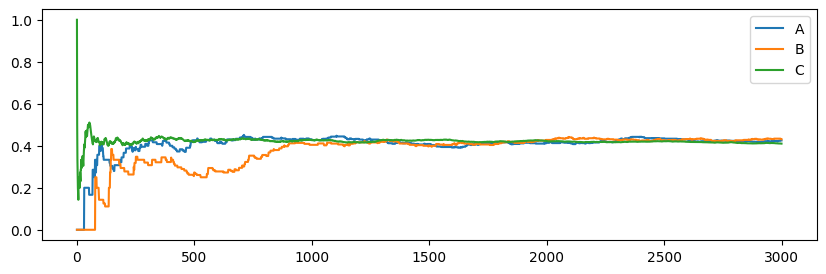

In [21]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(list(range(n)), ctrs[0], label='A')
plt.plot(list(range(n)), ctrs[1], label='B')
plt.plot(list(range(n)), ctrs[2], label='C')
plt.legend()
plt.show()

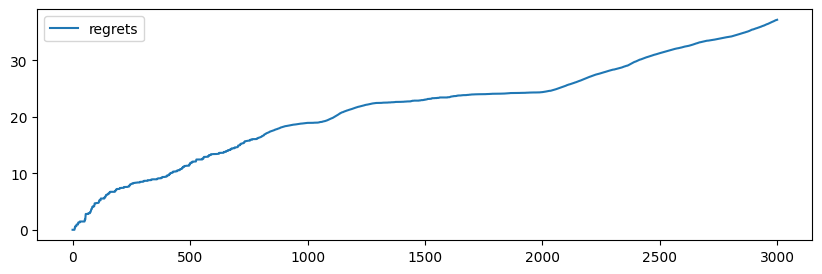

In [22]:
plt.plot(list(range(n)), regrets, label='regrets')
plt.legend()
plt.show()

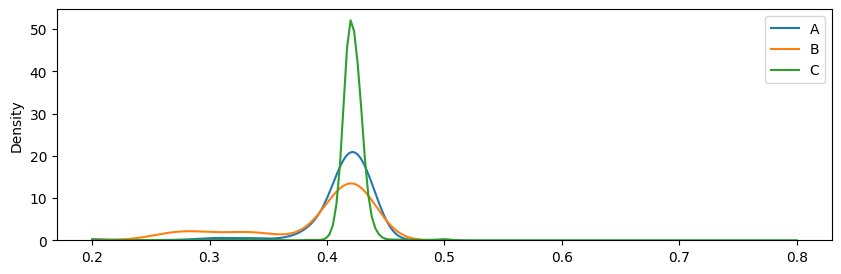

In [23]:
sns.kdeplot(ctrs[0], clip=(0.2, 0.8), label='A') 
sns.kdeplot(ctrs[1], clip=(0.2, 0.8), label='B')
sns.kdeplot(ctrs[2], clip=(0.2, 0.8), label='C')
plt.legend()

Проблема алгоритма в том, что за начальный период можно выбрать не того бандита, у которого фактически окажется самый высоки CTR.

### Сэмплирование Томпсона

Сэмплирование Томпсона использует бета-распределение.<br>
Плотность бета-распределения $\Theta$:

$f_\Theta(x)=\frac{1}{B(\alpha, \beta)}x^{\alpha - 1}(1 - x)^{\beta-1}$<br>
$B(\alpha, \beta)= \int\limits_0^1 x^{\alpha - 1}(1 - x)^{\beta - 1}dx; \alpha, \beta > 0$<br>

$E[\Theta]=\frac{\alpha}{\alpha + \beta}$<br>
$D[\Theta]=\frac{\alpha \beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$<br>


1. Задать распределения каждого автомата $R_i$ параметрами $\alpha_i$ и $\beta_i$.<br>
$\alpha_i = prior_i + reward_i$<br>
$\beta_i = prior_i + (1 - reward_i)$<br>
Для CTR:<br>
$\alpha_i = prior_i + clicks_i$<br>
$\beta_i = prior_i + (impressions_i - clicks_i)$

Если нет никакой предварительно известной информации, принять $prior_i=1$

In [24]:
alphas = [1] * k
betas = [1] * k
win_index = random.choice([0, 1, 2])

2. Просэмплировать каждое распределение и найти автомат с максимальным вознаграждением, использовать этот автомат в текущем эксперименте.
3. Повторять 1-2 в течение заданного промежутка времени.

In [25]:
index_list = [] 
impressions = np.zeros(k)
clicks = np.zeros(k)
ctrs = {i: [] for i in range(k)}
optimal_impressions_rate = 0
current_regret = 0
regrets = []

for i in range(n):    
    impressions[win_index] += 1
    did_click = click_bandit[bandit_index]()
    clicks[win_index] += did_click

    alphas[win_index] += did_click
    betas[win_index] += 1 - did_click
    step_ctrs = [np.random.beta(alphas[b], betas[b]) for b in range(k)]
    for b in range(k):
        ctrs[b].append(step_ctrs[b])
    
    optimal_impressions_rate += win_index == np.argmax(step_ctrs)
    current_regret += step_ctrs[np.argmax(step_ctrs)] - step_ctrs[win_index]
    regrets.append(current_regret) 
    win_index = np.argmax(step_ctrs)

for i in range(k):
    print(i, "interactions:\t", impressions[i])
    print(i, "interactions proportion:", impressions[i] / n)
    print(i, "CTR:\t", clicks[i] / impressions[i], "\n")
print("Total reward for", n, "impressions:", sum(clicks))
print("Optimal impressions rate:", optimal_impressions_rate)
print("Regret:", current_regret)

0 interactions:	 642.0
0 interactions proportion: 0.214
0 CTR:	 0.411214953271028 

1 interactions:	 1519.0
1 interactions proportion: 0.5063333333333333
1 CTR:	 0.41013824884792627 

2 interactions:	 839.0
2 interactions proportion: 0.2796666666666667
2 CTR:	 0.41477949940405245 

Total reward for 3000 impressions: 1235.0
Optimal impressions rate: 1351
Regret: 66.32634865201706


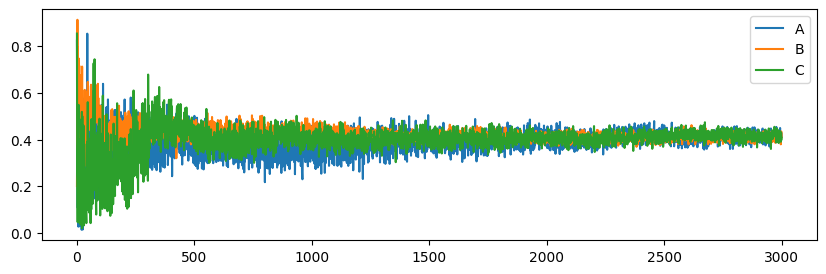

In [26]:
plt.rcParams["figure.figsize"] = (10,3)
plt.plot(list(range(n)), ctrs[0], label='A')
plt.plot(list(range(n)), ctrs[1], label='B')
plt.plot(list(range(n)), ctrs[2], label='C')
plt.legend()
plt.show()

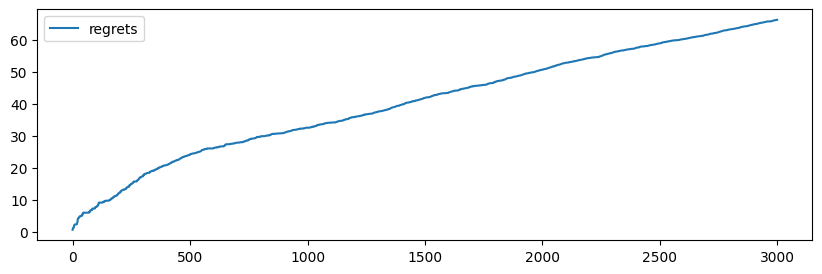

In [27]:
plt.plot(list(range(n)), regrets, label='regrets')
plt.legend()
plt.show()

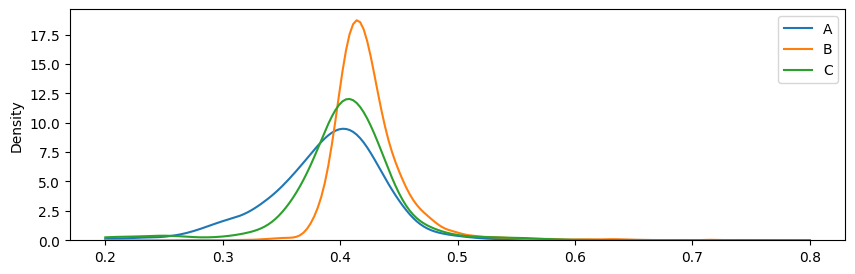

In [28]:
sns.kdeplot(ctrs[0], clip=(0.2, 0.8), label='A') 
sns.kdeplot(ctrs[1], clip=(0.2, 0.8), label='B')
sns.kdeplot(ctrs[2], clip=(0.2, 0.8), label='C')
plt.legend()